# Application: Estimating $H_0$ from Type Ia Supernovae

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [13]:
data = np.genfromtxt("SCPUnion2_mu_vs_z.txt",
                    dtype=[("name", "S6"), ("z", "f8"), ("mu", "f8"), ("dz", "f8")])

Text(0, 0.5, '$\\mu$')

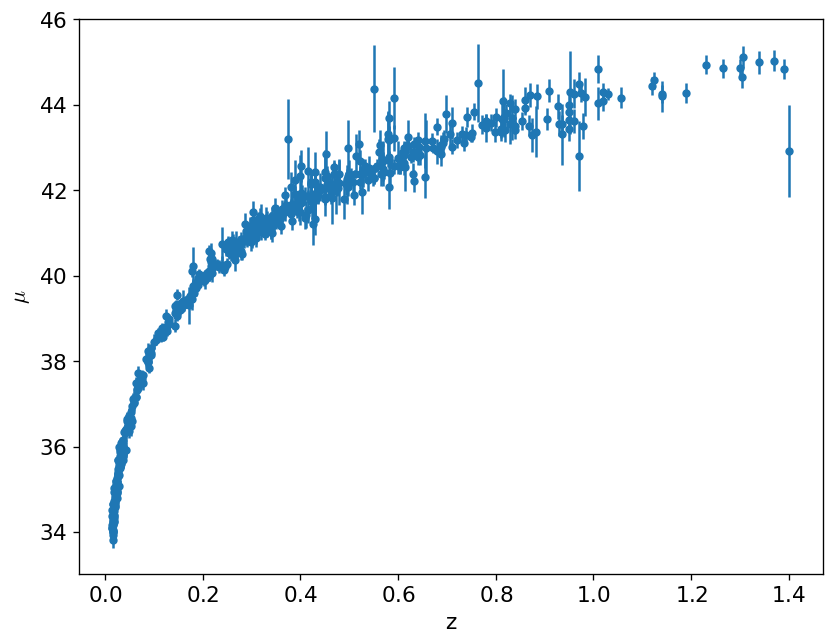

In [22]:
fig, ax = plt.subplots()
ax.errorbar(data["z"], data["mu"], yerr=data["dz"], fmt="o", ms=4)
ax.set_xlabel("z")
ax.set_ylabel(r"$\mu$")

The basic idea is that we have the [distance modulus](https://en.wikipedia.org/wiki/Distance_modulus), which is related to the magnitudes via:

$$\mu = m - M = 5 \log_{10} \left (\frac{d}{10~\mbox{pc}}\right )$$
